In [1]:
# Imports 
import os  
import pandas as pd  
from PIL import Image 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import torch
from tqdm import tqdm

In [2]:
transformPipeline = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor()
])

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class celebDataset(Dataset):
    
    def __init__(self, csvFile: str, imageDirectory: str, bboxFile: str, transform=None) -> None:
        """
        Args:
            csvFile (str): Path to the CSV file containing image labels.
            imageDirectory (str): Path to the image directory.
            bboxFile (str): Path to the CSV file containing bounding box data.
            transform: Transformations to apply to images (optional).
        """
        self.imageDirectory = imageDirectory
        self.imageName = pd.read_csv(csvFile)["image_id"]
        self.imageLabels = pd.read_csv(csvFile)["Arched_Eyebrows"]
        self.transform = transform
        
        # Load bounding box data
        self.bboxData = pd.read_csv(bboxFile)

    def __len__(self) -> int:
        return len(self.imageLabels)
    
    def __getitem__(self, index: int) -> tuple[Image.Image, int]:
        # Get Image
        image_name = self.imageName.iloc[index]
        image_path = os.path.join(self.imageDirectory, image_name)
        image = Image.open(image_path)

        # Get Label
        label = int(self.imageLabels.iloc[index])
        
        # Change label from -1 to 0
        if label == -1:
            label = 0
        
        x1 = 40
        y1 = 80
        width = 100
        height = 100
        # Crop the image using the bounding box (left, upper, right, lower)
        # image = image.crop((x1, y1, x1 + height, y1 + width))

        # Apply transformations if provided
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label  # Return the image tensor and label


In [4]:
image_dir = "../img_align_celeba"
csv = "../Arched_Eyebrows.csv"
bbox = "../face_image_bbox.csv"
dataset = celebDataset(csv, image_dir,bbox, transformPipeline)

In [5]:
print(len(dataset))

108412


In [6]:
for i in range(5):
    image,label = dataset[i+1]
    print(f"Label for {i}th image is {label}")

Label for 0th image is 1
Label for 1th image is 1
Label for 2th image is 1
Label for 3th image is 1
Label for 4th image is 1


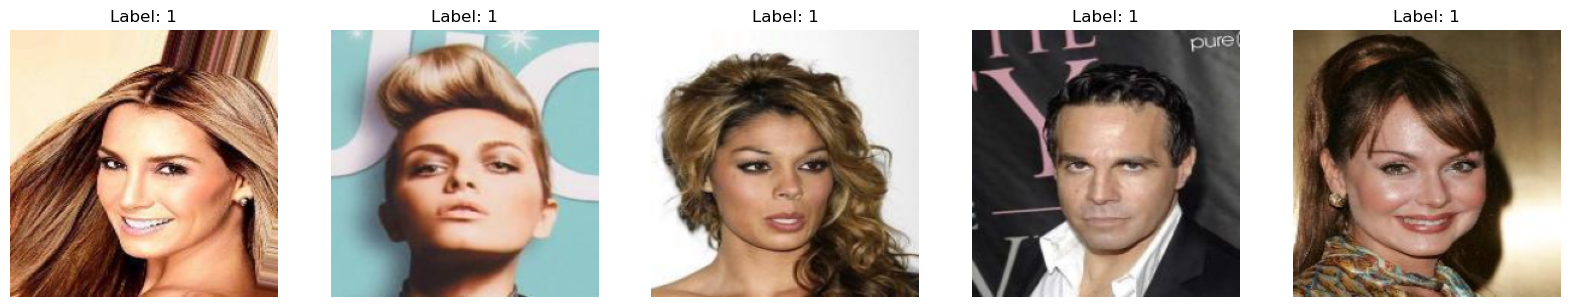

In [7]:
# plot few images 
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    img, label = dataset[i]
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    ax[i].set_title(f"Label: {label}")
    ax[i].axis("off")
plt.show()


In [8]:
image,label = dataset[2]
print(image.shape)

torch.Size([3, 224, 224])


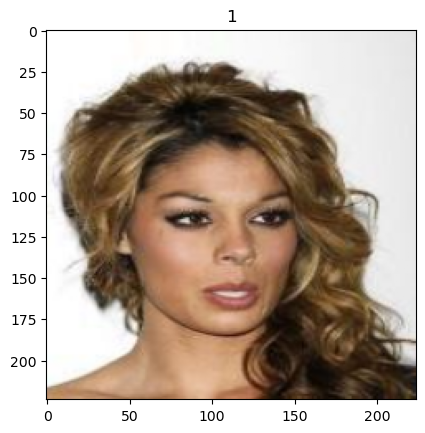

In [9]:
# plot this image
plt.imshow(image.permute(1,2,0))
plt.title(label)
plt.show()

In [10]:
trainSize = int(0.8*len(dataset))
validationSize = int(0.2*(len(dataset)))

    
# These are remaining data points
offset = (len(dataset)-trainSize-validationSize)

print(f"Training Set Size: {trainSize}, Validation Set Size: {validationSize+offset}")

Training Set Size: 86729, Validation Set Size: 21683


In [11]:
# Split the dataset
trainSet, validSet = torch.utils.data.random_split(dataset,[trainSize,validationSize+offset])

In [12]:
# make the dataloader
batchsize = 64

trainLoader = DataLoader(trainSet,batch_size=batchsize,shuffle=True)
validLoader = DataLoader(validSet,batch_size=batchsize,shuffle=True)


In [13]:

import torchvision.models as models
import torch.nn as nn

# Load pre trained resnet model
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

numFeatures = model.fc.in_features
print(numFeatures)
model.fc = nn.Sequential(
    nn.Linear(numFeatures, 256),  # First hidden layer
    nn.ReLU(),                    # Activation function
    nn.Dropout(0.8),               # Dropout for regularization (optional)
    nn.Linear(256, 2),           # Output layer for binary classification
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

512
cuda


In [14]:
from torchinfo import summary

# Assuming 'model' is your defined ResNet18 model
summary(model, input_size=(1, 3, 224, 224))  # Note: Batch size of 1 is specified here


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [15]:
# Loss Function
import torch.nn as nn 
lossFunction = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)


In [16]:
import torch
from tqdm import tqdm
from colorama import Fore, Style

# Training Loop with Progress Bar and Colorful Output
numEpochs = 20
model.to(device)

for epoch in range(numEpochs):
    model.train()
    running_loss = 0.0
    print(f"{Fore.CYAN}Epoch [{epoch + 1}/{numEpochs}]{Style.RESET_ALL}")
    
    # Use tqdm for progress bar in training
    train_loader_tqdm = tqdm(enumerate(trainLoader), total=len(trainLoader), desc=f"{Fore.YELLOW}Training Epoch {epoch + 1}{Style.RESET_ALL}")
    
    for batchIndex, (images, labels) in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = lossFunction(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # if batchIndex % 100 == 0:
        train_loader_tqdm.set_postfix(loss=loss.item())
            
    # Print epoch loss
    avg_loss = running_loss / len(trainLoader)
    print(f"{Fore.GREEN}Epoch {epoch + 1}, Average Training Loss: {avg_loss:.4f}{Style.RESET_ALL}")
    
    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(validLoader, desc=f"{Fore.YELLOW}Validating{Style.RESET_ALL}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    accuracy = correct / total
    print(f"{Fore.BLUE}Epoch {epoch + 1}, Validation Accuracy: {accuracy:.4f}{Style.RESET_ALL}")

    # Save the model pth file
torch.save(model.state_dict(), "model_crop2.pth")



Epoch [1/20]


Training Epoch 1: 100%|██████████| 1356/1356 [03:14<00:00,  6.98it/s, loss=0.385]


Epoch 1, Average Training Loss: 0.5662


Validating: 100%|██████████| 339/339 [00:47<00:00,  7.18it/s]


Epoch 1, Validation Accuracy: 0.7501
Epoch [2/20]


Training Epoch 2: 100%|██████████| 1356/1356 [02:30<00:00,  9.02it/s, loss=0.416]


Epoch 2, Average Training Loss: 0.5477


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.48it/s]


Epoch 2, Validation Accuracy: 0.7586
Epoch [3/20]


Training Epoch 3: 100%|██████████| 1356/1356 [02:30<00:00,  9.00it/s, loss=0.506]


Epoch 3, Average Training Loss: 0.5408


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.52it/s]


Epoch 3, Validation Accuracy: 0.7593
Epoch [4/20]


Training Epoch 4: 100%|██████████| 1356/1356 [02:30<00:00,  8.99it/s, loss=0.379]


Epoch 4, Average Training Loss: 0.5369


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.64it/s]


Epoch 4, Validation Accuracy: 0.7594
Epoch [5/20]


Training Epoch 5: 100%|██████████| 1356/1356 [02:28<00:00,  9.11it/s, loss=0.717]


Epoch 5, Average Training Loss: 0.5358


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.48it/s]


Epoch 5, Validation Accuracy: 0.7624
Epoch [6/20]


Training Epoch 6: 100%|██████████| 1356/1356 [02:29<00:00,  9.09it/s, loss=0.478]


Epoch 6, Average Training Loss: 0.5340


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.44it/s]


Epoch 6, Validation Accuracy: 0.7600
Epoch [7/20]


Training Epoch 7: 100%|██████████| 1356/1356 [02:29<00:00,  9.04it/s, loss=0.35] 


Epoch 7, Average Training Loss: 0.5325


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.57it/s]


Epoch 7, Validation Accuracy: 0.7504
Epoch [8/20]


Training Epoch 8: 100%|██████████| 1356/1356 [02:31<00:00,  8.95it/s, loss=0.609]


Epoch 8, Average Training Loss: 0.5317


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.57it/s]


Epoch 8, Validation Accuracy: 0.7614
Epoch [9/20]


Training Epoch 9: 100%|██████████| 1356/1356 [02:30<00:00,  9.03it/s, loss=0.676]


Epoch 9, Average Training Loss: 0.5309


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.46it/s]


Epoch 9, Validation Accuracy: 0.7600
Epoch [10/20]


Training Epoch 10: 100%|██████████| 1356/1356 [02:30<00:00,  8.98it/s, loss=0.499]


Epoch 10, Average Training Loss: 0.5286


Validating: 100%|██████████| 339/339 [00:36<00:00,  9.28it/s]


Epoch 10, Validation Accuracy: 0.7631
Epoch [11/20]


Training Epoch 11: 100%|██████████| 1356/1356 [02:29<00:00,  9.07it/s, loss=0.508]


Epoch 11, Average Training Loss: 0.5277


Validating: 100%|██████████| 339/339 [00:36<00:00,  9.36it/s]


Epoch 11, Validation Accuracy: 0.7630
Epoch [12/20]


Training Epoch 12: 100%|██████████| 1356/1356 [02:31<00:00,  8.98it/s, loss=0.47] 


Epoch 12, Average Training Loss: 0.5279


Validating: 100%|██████████| 339/339 [00:36<00:00,  9.31it/s]


Epoch 12, Validation Accuracy: 0.7642
Epoch [13/20]


Training Epoch 13: 100%|██████████| 1356/1356 [02:28<00:00,  9.13it/s, loss=0.345]


Epoch 13, Average Training Loss: 0.5279


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.49it/s]


Epoch 13, Validation Accuracy: 0.7643
Epoch [14/20]


Training Epoch 14: 100%|██████████| 1356/1356 [02:29<00:00,  9.09it/s, loss=0.399]


Epoch 14, Average Training Loss: 0.5284


Validating: 100%|██████████| 339/339 [00:34<00:00,  9.76it/s]


Epoch 14, Validation Accuracy: 0.7635
Epoch [15/20]


Training Epoch 15: 100%|██████████| 1356/1356 [02:31<00:00,  8.96it/s, loss=0.35] 


Epoch 15, Average Training Loss: 0.5272


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.56it/s]


Epoch 15, Validation Accuracy: 0.7602
Epoch [16/20]


Training Epoch 16: 100%|██████████| 1356/1356 [02:29<00:00,  9.05it/s, loss=0.57] 


Epoch 16, Average Training Loss: 0.5265


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.42it/s]


Epoch 16, Validation Accuracy: 0.7620
Epoch [17/20]


Training Epoch 17: 100%|██████████| 1356/1356 [02:29<00:00,  9.07it/s, loss=0.446]


Epoch 17, Average Training Loss: 0.5268


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.64it/s]


Epoch 17, Validation Accuracy: 0.7632
Epoch [18/20]


Training Epoch 18: 100%|██████████| 1356/1356 [02:28<00:00,  9.12it/s, loss=0.521]


Epoch 18, Average Training Loss: 0.5269


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.55it/s]


Epoch 18, Validation Accuracy: 0.7619
Epoch [19/20]


Training Epoch 19: 100%|██████████| 1356/1356 [02:29<00:00,  9.08it/s, loss=0.652]


Epoch 19, Average Training Loss: 0.5283


Validating: 100%|██████████| 339/339 [00:35<00:00,  9.45it/s]


Epoch 19, Validation Accuracy: 0.7664
Epoch [20/20]


Training Epoch 20: 100%|██████████| 1356/1356 [02:26<00:00,  9.23it/s, loss=0.561]


Epoch 20, Average Training Loss: 0.5251


Validating: 100%|██████████| 339/339 [00:34<00:00,  9.77it/s]


Epoch 20, Validation Accuracy: 0.7654


In [16]:
testSet = celebDataset("../testSet.csv", image_dir,bbox, transformPipeline)

In [17]:
print(len(testSet)) 

19962


In [18]:
testLoader = DataLoader(testSet, batch_size=batchsize, shuffle=False)

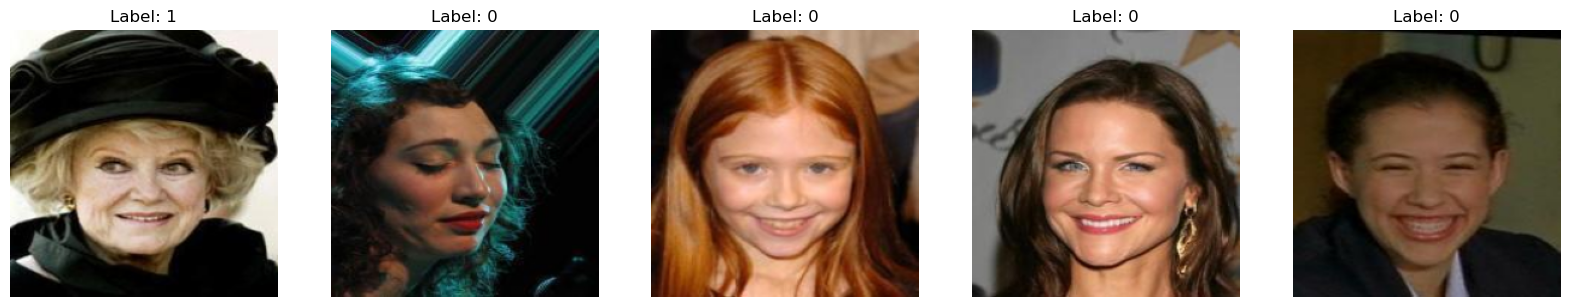

In [19]:
# Visualize few images on test set
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    img, label = testSet[i]
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    ax[i].set_title(f"Label: {label}")
    ax[i].axis("off")
plt.show()


In [20]:
# move to device
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Predicted Class: 1
Probability of Class 1: 0.9959583878517151
Prediction: Arched Eyebrows


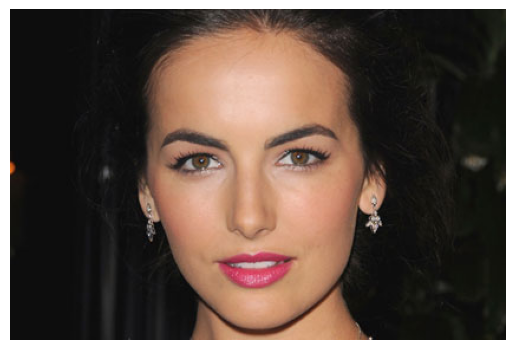

In [22]:
# Test on a single image
from PIL import Image
import torch
from torchvision import transforms

# Load the image
image_path = "../TestImages/test3.png"
image = Image.open(image_path)

# Apply transformations
transformPipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the image and preprocess it
def preprocess_image(image_path):
    image = Image.open(image_path)

    # If the image has 4 channels (RGBA), convert it to 3 channels (RGB)
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply transformations (resize, normalize, etc.)
    image_tensor = transformPipeline(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

image_tensor = preprocess_image(image_path)

# plot the image
plt.imshow(image)

# Load the model
model = models.resnet18()
numFeatures = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(numFeatures, 256),  # First hidden layer
    nn.ReLU(),                    # Activation function
    nn.Dropout(0.8),               # Dropout for regularization (optional)
    nn.Linear(256, 2),           # Output layer for binary classification
)

model.load_state_dict(torch.load("model_crop.pth"))
model.eval()

# Make prediction
with torch.no_grad():
    output = model(image_tensor)
    probs = torch.softmax(output, dim=1)
    _, predicted = torch.max(output, 1)
    
    print(f"Predicted Class: {predicted.item()}")
    print(f"Probability of Class 1: {probs[0, 1].item()}")
    
    if predicted.item() == 0:
        print("Prediction: No Arched Eyebrows")
    else:
        print("Prediction: Arched Eyebrows")
        
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    

Testing: 100%|██████████| 312/312 [00:43<00:00,  7.18it/s]

Final Test Accuracy: 0.8026
Precision: 0.6108
Recall: 0.8434
F1 Score: 0.7085
Confusion Matrix:
[[11232  3052]
 [  889  4789]]


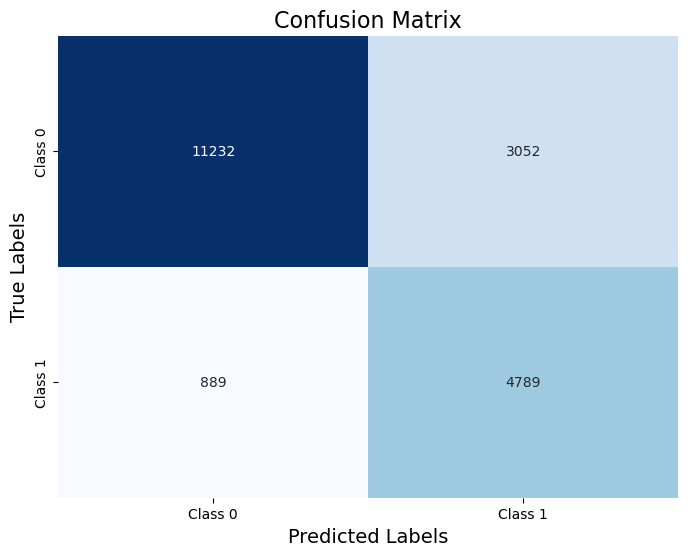

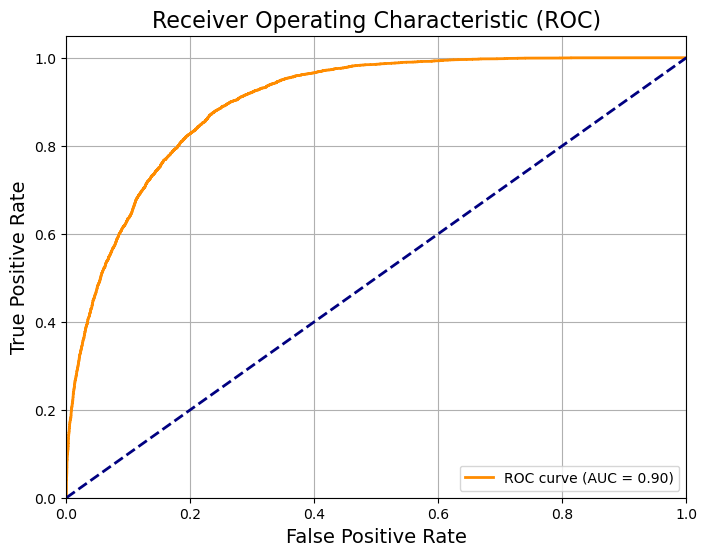

In [23]:
all_labels = []
all_preds = []
all_probs = []

model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(testLoader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Compute precision, recall, F1 score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Beautify confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with improved visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()